In [5]:
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.cross_validation import cross_val_score;
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error

In [6]:
%matplotlib inline
IN_PATH     = ('../data/')

First let us read in the processed dataframes, and generate appropriate dataframes for some simple exploratory data analysis.

In [7]:
# read all 14-19 season data
path_list = glob.glob('{}*.csv'.format(IN_PATH))
df_list = [pd.read_csv(path) for path in path_list]

# identify EPL teams and relagated teams for each season
epl_list = [pd.concat([df[:17], df[20:]]).reset_index(drop=True) for df in df_list]

# concat seasons 14-18 for analysis
df_tot = pd.concat(df for df in epl_list[:-1])
features = [col for col in df_tot.columns if col not in ('lead_pts', 'team')]
res  = ['lead_pts']

The below scatter plots display the relationship between each feature in our dataframes and the target variable lead_pts.

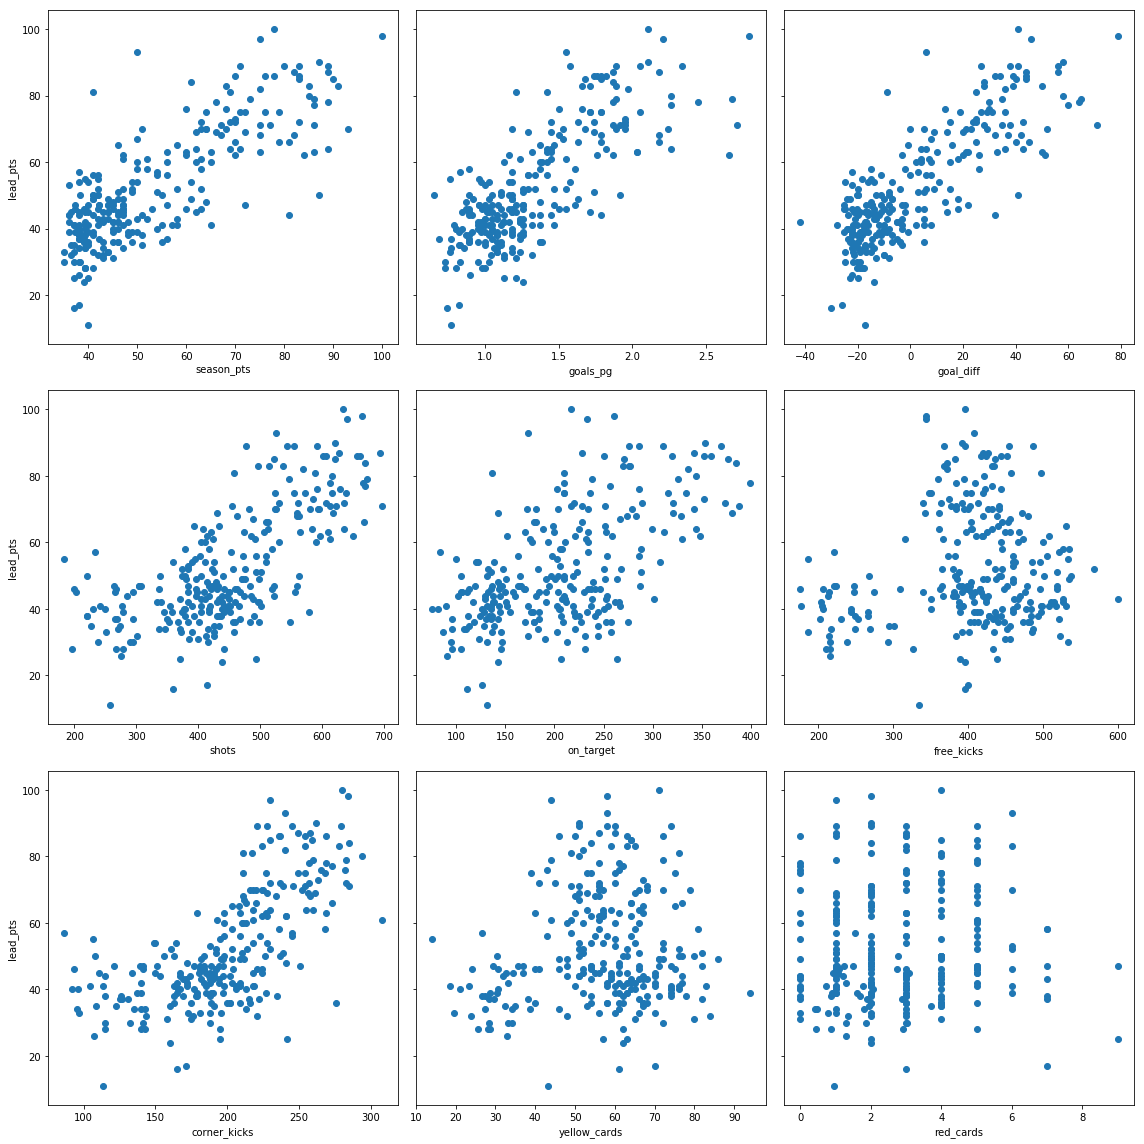

In [8]:
# configure plot
fig, axes = plt.subplots(3, 3, figsize=(16,16),sharey=True)
arr = np.array(features).reshape(3, 3)

# iterate over all features
for row, col_arr in enumerate(arr):
    # plot each feature against lead_pts
    for col, feature in enumerate(col_arr):
        axes[row, col].scatter(df_tot[feature], df_tot['lead_pts'])
        if col == 0:
            axes[row, col].set(xlabel=feature, ylabel='lead_pts')
        else:
            axes[row, col].set(xlabel=feature)

fig.tight_layout()
plt.show()

It is evident that all the features with the exception of number of free kicks, yellow cards and red cards a fairly strong linear relathionship with the leading season's points. The number of yellow/red cards per season seems to be more random.

We know that even within the same division, the performance of the teams are vastly different, especially between the teams that consistently compete in the Champion's League (i.e. top 4 each season) and the teams that below average performance.  

To see if the different groups affect the above relationships, let us observe the relationship between shots and leading season's points for two groups: the top 4 teams each season, and the teams that rank the bottom 3 of the teams that successfully remained in the premier league (i.e. ranks 14-17).

Note: To really see the difference, it would be ideal to compare top 4 vs the relegated teams each season. But since we are looking at the leading season's points and not the current season's points, relegated teams cannot be considered because they are not in the premier league the next season.

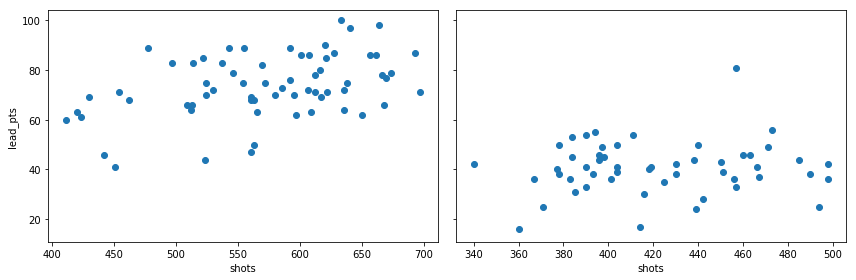

In [9]:
# configure plot
fig, axes = plt.subplots(1, 2, figsize=(12,4),sharey=True)

# select teams compeating in the Champions League/relegated teams
df_top = pd.concat(df.loc[:4] for df in epl_list)
df_bottom = pd.concat(df.loc[13:16] for df in epl_list)
df = [df_top, df_bottom]

# populate subplots
for i, ax in enumerate(axes):
    if i == 0:
        ax.set_ylabel('lead_pts')
    ax.set_xlabel('shots')
    ax.scatter(df[i].shots, df[i].lead_pts)

fig.tight_layout()
plt.show()

It is interesting to see that for the top tier teams, the leading season's points increases linearly as the number of shots taken increases, but in the other group, the leading season's points remains relatively constant. This may be something we can refer back to if it turns out that our model predictions for teams with weak performances have issues.

Now moving on to the feature selection process, we will start by examining the univariate correlation of each input feature with the target variable.

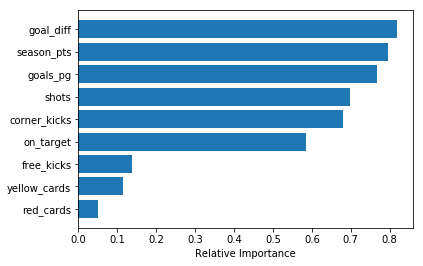

In [10]:
# calculate univariate feature importance 
feat_importance = df_tot.drop(['team', 'lead_pts'], axis=1).apply(lambda x: x.corr(df_tot.lead_pts))
order = np.argsort(feat_importance)
feat_importance[order]

# generate feature importance plot
plt.barh(range(len(order)), feat_importance[order], align='center')
plt.yticks(range(len(order)), [features[i] for i in order])
plt.xlabel('Relative Importance')
plt.show()

# drop unwanted features
features = [features[i] for i in order if feat_importance[i] > 0.4]
features.insert(0, 'team')

We will drop features with the correlation coefficient less than 0.4, and thus the number of free kicks, yellow cards, and red cards will be dropped from the set of features. We can now observe the correlation heatmap to check correlation between remaining features.

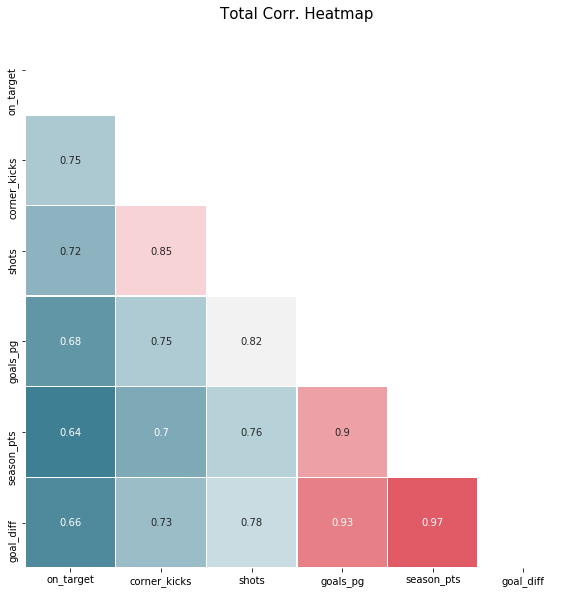

In [12]:
# generate correlation heatmap for seasons 14-18
fig, ax = plt.subplots(1, figsize=(15,10))
ax.set_title('Total Corr. Heatmap', size=15)

# correlation matrix
corr = df_tot[features].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, annot=True, 
            cbar=False, square=True, linewidths=.5, ax=ax)
plt.show()

As expected, many of the features have high correlation amongst one another. However, we will not check for multicollinearity because we are only interested in the predictive accuracy, not the impact of each feature on the target.

We are now ready for fitting our model, we will start with the linear regression model to see how it performs.

In [13]:
# divide dataframe into design matrix and output vector
df_tot = df_tot.reset_index(drop=True)
X = df_tot[features].drop(columns=['team'])
y = df_tot.lead_pts

In [14]:
# generate linear model
lm = LinearRegression()

# evaluate model
lm_cv_scores = cross_val_score(lm, X, y, cv=5, scoring='neg_mean_absolute_error')*-1
print('MAE of {:.2f} points (+/-) {:.2f} points'.format(np.mean(lm_cv_scores), np.std(lm_cv_scores)))

MAE of 7.95 points (+/-) 0.56 points


The linear regression model produced a mean absolute error of ~8 points. We can see how significant 8 points really is by comparing the total points earned in a season between teams. We will take the last season (18/19) as an example:

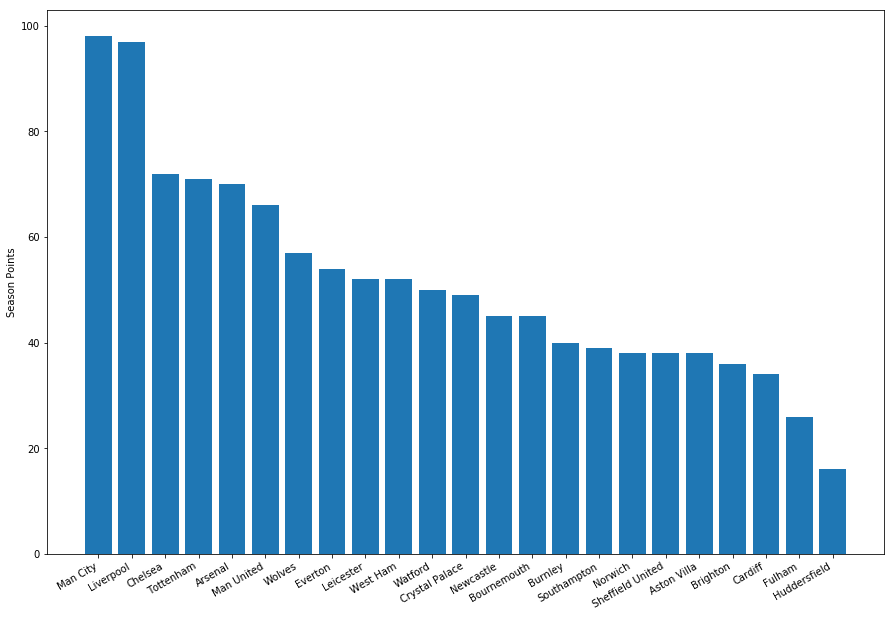

In [15]:
# last season (i.e. 18/19)
df = df_list[-1].sort_values(by=['season_pts'], ascending=False)

# add barchart to compare season points
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.bar(df.team, df.season_pts)
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.ylabel('Season Points')

plt.show()

We can see that the 1st and 2nd place were quite close (in fact they were only off by 1 point), and there is a large gap between the 2nd and the 3rd placed teams. The 3rd to 5th place teams all earned similar number of points (again, only off by 2 points), and there is another drop, and so on.

It is evident that 8 points is a significant enough number, meaning that the predicted standings can be quite different from the actual standings. Let us explore other models to see if we can lower the MAE. It may be the case that there are non-linearities that cannot be captured by the linear regression model, so we will now try using a neural network model.

Let us first normalize the data, and split the data into training and testing sets.

In [16]:
# for reproducibility
np.random.seed(43)

# normalize data
scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print('{} training samples'.format(X_train.shape[0]))
print('{} testing samples'.format(X_test.shape[0]))

208 training samples
52 testing samples


We can now perform a simple parameter estimation through grid search cross validation. We will attempt to find hyperparameters that result in model performance equal to or better than the linear regression model.

In [17]:
def create_model():
    """ create_model
        Output: 
            <keras Sequential model> model : keras sequential model with 2 hidden layers 
                                             and 1 dropout layer
    """   
    # define model
    model = Sequential()
    model.add(Dense(36, input_dim=6, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(36, activation='relu'))
    model.add(Dense(1, activation='linear'))

    # compile model
    model.compile(loss='mean_absolute_error', optimizer = 'adam')
    
    return model

In [19]:
# hyperparameters
batch_size = 1
epochs = 10

model_cv = KerasRegressor(build_fn=create_model, verbose=0)

# define the grid search parameters
batch_sizes = [1, 105, 208]
epochs      = [10, 50, 100]

param_grid = dict(epochs=epochs, batch_size=batch_sizes)

# perform grid search for initializer, number of epochs, and batch size
grid = GridSearchCV(estimator=model_cv, param_grid=param_grid, cv=10, scoring='neg_mean_absolute_error')
grid_results = grid.fit(X_train, y_train, verbose=0)

In [20]:
# print results
print('Best MAE of {:.2f} using parameters {}'.format(grid_results.best_score_*-1, 
                                                     grid_results.best_params_))

Best MAE of 7.98 using parameters {'epochs': 50, 'batch_size': 1}


In [21]:
# fit model using the best parameters
model_cv.fit(X_train, y_train, epochs=50, batch_size=1, verbose=0)
pred = model_cv.predict(X_test)

# compute the MAE
score = mean_absolute_error(y_test, pred)
print('MAE of {:.2f}'.format(score)) 

MAE of 7.08


The performance of the neural network model is comparable to the linear regression model, with a lack of a significant improvement. In reality, there is so much more going on in the premier league that the previous season's performance alone cannot adequately capture the performance of the current season (i.e. for instance, the manager of each club, foreign money invested in club, buying/selling franchise stars, and the list is endless).

Just for fun, we will predict the outcome of the current (19/20) season, where only 22 of the 38 rounds have been played, using the linear regression model. We compare the predictions to the current league standings, and see if there are some realistic predictions that were made.

In [23]:
# current standings for roudn 22 of 38
curr_standings = ['Liverpool', 'Man City', 'Leicester', 'Chelsea', 'Man United', 'Sheffield',
                  'Wolves', 'Tottenham', 'Crystal Palace', 'Arsenal', 'Everton', 'Southampton',
                  'Newcastle', 'Brighton', 'Burnley', 'West Ham', "Watford", 'Aston Villa',
                  'Bournmouth', 'Norwich']
curr_pts = [61, 47, 45, 39, 34, 32, 31, 30, 29, 28, 28, 28, 26, 24, 24, 22, 22, 21, 20, 14]

# current season matrix
X_curr = epl_list[-1][features]

# fit model
lm.fit(X,y)

# generate predictions
pred = lm.predict(X_curr.drop(columns=['team']))

res = pd.DataFrame({'teams_predicted': X_curr.team, 'predictions': pred.round().astype(int)}) \
                    .sort_values(by=['predictions'], ascending=False).reset_index(drop=True) 
res['curr_standing'] = curr_standings
res['curr_pts'] = curr_pts
res

,predictions,teams_predicted,curr_standing,curr_pts
0,12187,Man City,Liverpool,61
1,10785,Liverpool,Man City,47
2,7872,Chelsea,Leicester,45
3,7442,Tottenham,Chelsea,39
4,6883,Arsenal,Man United,34
5,6381,Man United,Sheffield,32
6,6185,Everton,Wolves,31
7,5923,Leicester,Tottenham,30
8,5425,Crystal Palace,Crystal Palace,29
9,5413,Wolves,Arsenal,28


Some predictions seem more realistic than others (i.e. Manchester City, Liverpool, Chelsea being placed within the top 3, Aston Villa, Norwich being placed within/near relegation), while other predictions don't seem very likely (Leicester finishing 8th, Tottenham Finishing 4th).

The above mentioned teams with realistic predictions are performing very similar to the previous season. The teams with predictions that seem very unlikely are all teams that are performing significantly different from the previous season. For instance, Leicester finished 9th last season, but are currently in 3rd place right now. There are clear limitations to only using the previous year's performance as the indicator of current season's performance.

In conclusion, to provide better predictions, we will likely need more relevant features in the dataset to model the complex nature of the premier league. For instance, we could add amount spent in the transfer market for each team, or add a metric to quantify the competency of the manager of each team (possibly borrowing attributes from FM). We could also try and go a few years further instead of just the previous year to predict the current season.